In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tabulate import tabulate
from multiprocessing import Pool
from scipy.ndimage import uniform_filter1d
import matplotlib.colors as mcolors
import tqdm.notebook as tqdm

# import the C++ module
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Gillespie_backend')
import Gillespie_backend as backend
import Simulate_System as SimSys

sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/super_simple_simulation/')

import Super_Simple_System as SSSys
import Super_Simple_Stochastic_Matrix as SSSMatrix


In [2]:
# define the unit of the system :
R = 50
L = 100
Eb = -10.
kdiff = 0.000207352
size = 100
dangling = True

In [3]:
Sys = backend.Gillespie(ell_tot=L,rho0=0.,BindingEnergy=Eb,kdiff=kdiff*5,seed = np.random.randint(0,1000000),Nlinker=3,dimension=1)
Sys_2 = backend.Gillespie(ell_tot=L,rho0=0.,BindingEnergy=Eb,kdiff=kdiff*5,seed = np.random.randint(0,1000000),Nlinker=10,dimension=1)

In [4]:
Sys_2.evolve(10**6)

6393


ValueError: wrong number of linkers

In [4]:
Sim = SimSys.Simulation(step_tot = 10**6,size=100,L_size=100,Gillespie = Sys)
Sim.simulate_eq_distribution()

In [4]:
Sim_2 = SimSys.Simulation(step_tot = 10**6,size=100,L_size=100,Gillespie = Sys_2)
Sim_2.simulate_eq_distribution()

[[-1.40489824  0.          0.        ]
 [-1.33343435  0.          0.        ]
 [-1.32847618  0.          0.        ]
 [-0.60856465  0.          0.        ]
 [-0.58749717  0.          0.        ]
 [-0.31081597  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.39316409  0.          0.        ]
 [ 0.48090003  0.          0.        ]]

[[-1.40489824  0.          0.        ]
 [-1.33343435  0.          0.        ]
 [-1.32847618  0.          0.        ]
 [-0.60856465  0.          0.        ]
 [-0.58749717  0.          0.        ]
 [-0.31081597  0.          0.        ]
 [ 0.39316409  0.          0.        ]
 [ 0.48090003  0.          0.        ]]


ValueError: could not broadcast input array from shape (8,3) into shape (9,3)

In [18]:
def make_2D_statistics(R,bins=100):
    #bins=100
    maxR = np.max(R)
    if R.shape[1] != 2 :
        print('The shape of the array does not match the function, expected (N,2) : 2 linkers ')
    def I(r):
        return int(r/maxR*(bins-1))
    X,Y = np.linspace(0,maxR,bins),np.linspace(0,maxR,bins)
    X,Y = np.meshgrid(X,Y)
    PR2D = np.zeros((bins,bins),dtype=float)
    for r in tqdm.tqdm(R):
        PR2D[I(np.linalg.norm(r[0])),I(np.linalg.norm(r[1]))] += 1/R.shape[0]
    return X,Y,PR2D
def compute_2_body_dist_prob(R,bins=100):
    maxR = np.max(R)
    ddist = maxR/(bins-1)
    if R.shape[1] != 2 :
        print('The shape of the array does not match the function, expected (N,2) : 2 linkers ')
    def I(dist):
        return int(dist/ddist)
    def v_shell(dist):
        return 4/3*np.pi*((dist+ddist)**3 - dist**3)
    X = np.linspace(0,maxR,bins,endpoint=False)
    PR = np.zeros(bins,dtype=float)
    for r in R:
        for r1,r2 in zip(r[:1],r[1:]):
            if any(r1!=r2):
                PR[I(np.linalg.norm(r1-r2))] +=1/v_shell(np.linalg.norm(r1-r2))*1/(R.shape[0]*R.shape[1])
    return X,PR

In [7]:
#with Pool(10) as p:
#    res = p.map(make_2D_statistics,np.array([Sim.R[i*Sim.R.shape[0]//10:(i+1)*Sim.R.shape[0]//10] for i in range(10)]))
X,Y,Z = make_2D_statistics(Sim.R)

  0%|          | 0/1000000 [00:00<?, ?it/s]

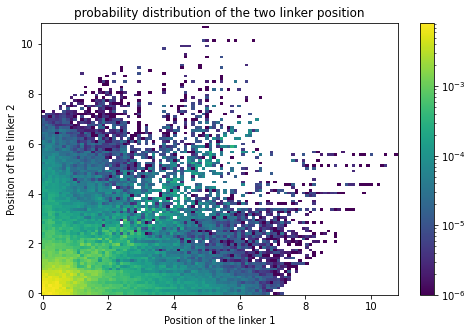

In [9]:
fig,ax = plt.subplots(figsize=(8,5))
psm = ax.pcolormesh(X,Y,Z,norm=mcolors.LogNorm())
ax.set_xlabel('Position of the linker 1')
ax.set_ylabel('Position of the linker 2')
ax.set_title('probability distribution of the two linker position')
cba = plt.colorbar(psm)

In [ ]:
X,Y = compute_2_body_dist_prob(Sim.R)
X2,Y2 = compute_2_body_dist_prob(Sim_2.R)

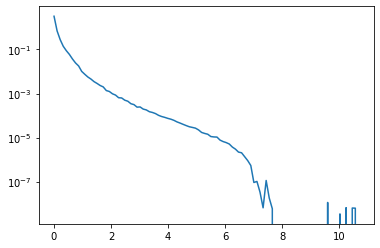

In [ ]:
plt.plot(X,Y)
plt.plot(X2,Y2)
plt.yscale('log')